# Can online customers' purchasing intention be predicted beforehand using the power of ML?

In [ ]:
# To be able to run on Google Colab
!wget https://raw.githubusercontent.com/berkaycanogullari/MSDS621_Proj/main/online_shoppers_intention.csv

In [1]:
# Import necessary libraries and packages

import pandas as pd
import numpy as np
import imblearn
import matplotlib.pyplot as plt

from imblearn.pipeline          import make_pipeline
from imblearn.over_sampling     import SMOTE
from sklearn.pipeline           import Pipeline
from sklearn.model_selection    import train_test_split, RandomizedSearchCV
from sklearn.linear_model       import LogisticRegression
from sklearn.ensemble           import RandomForestClassifier 
from sklearn.impute             import SimpleImputer
from sklearn.preprocessing      import StandardScaler, OneHotEncoder
from sklearn.metrics            import balanced_accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.compose            import ColumnTransformer
from sklearn.inspection         import permutation_importance
from sklearn                    import set_config
set_config('diagram')
import warnings
warnings.filterwarnings('ignore')

## NOTE! Results may change on Colab due to the randomness in train/test split and ML algorithms. Check GitHub repo notebook for correct interpretations.

# DATASET

In [2]:
# Read in the data

data = pd.read_csv('online_shoppers_intention.csv')

In [3]:
# Take a glance at the dataset

data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [4]:
# Size

data.shape

(12330, 18)

- There are no missing(np.nan) values in any of the columns based on pandas inspection
- Further inspection is done on a seperate notebook to see if missing values encoded differently than np.nan
- After doing EDA, I still have the same conclusion. **There aren't any missing values**

## Check target balance

In [5]:
revenue_positive = data.Revenue.sum() # Total class 1
revenue_negative = (~data.Revenue.values).sum() # Total class 0

revenue_positive, revenue_negative

(1908, 10422)

- Target is **imbalanced** and needed to be treated accordingly
- Approximately 16% of the data is *class 1*, rest is *class 0*

## Train/Test split

In [6]:
# Define features and label

X, y = data.drop('Revenue', axis=1), data.Revenue
y = y.values.ravel() # numpy trick to be able to split to train/test

- Use **stratified splitting** based on target since the dataset is imbalanced
- Important to do **before** applying any transformations

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2) # 0.8/0.2 stratified splitting

# Preprocessing and Feature Engineering

In [8]:
# Define categorical and continuous features to preprocess accordingly

cat_cols = ['SpecialDay', 'Month', 'OperatingSystems', 'Browser',
            'Region', 'TrafficType', 'VisitorType', 'Weekend']

con_cols = ['Administrative', 'Administrative_Duration', 'Informational',
            'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
            'BounceRates', 'ExitRates', 'PageValues']

## Categorical Variables

Even though there aren't any missing values at the moment, it doesn't mean we aren't going to have missing values in the future. Hence, the need for imputer.

- **Imputation**: *Most frequent imputation* for simplicity and fast modeling. Other options *kNNimputer*, *IterativeImputer*, *Learned Complex Model*...
- **Encoding**: *One Hot Encode* as there isn't high cardinality. Okay if not done or *Ordinal Encoding* for tree based algorithms but *OHE* has to be done for linear models.

In [9]:
# Pipeline for categorical variables

cat_pipe = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent', add_indicator=True)), # Median Impute
                     ('ohe', OneHotEncoder(handle_unknown='ignore'))]) # One Hot Encode

## Continuous Variables

Imputer is needed for same reasoning as categorical variables

- **Imputation**: *Median imputation* for simplicity and fast modeling. Same options exist as categorical.
- **Encoding**: *Variance scaling* as it makes modeling faster. Okay if not done for tree based models but improves linear models because of faster gradient descent.

In [10]:
# Pipeline for continuous variables

con_pipe = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='median', add_indicator=True)), # Mean Impute
                     ('scaler', StandardScaler())]) # Variance scale

## Column transformer to put everything together

In [11]:
preprocessing = ColumnTransformer([('categorical', cat_pipe, cat_cols), # Preprocess categorical variables
                                   ('continuous', con_pipe, con_cols)]) # Preprocess continuous variables

In [12]:
preprocessing # Show the steps for preprocessing

ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['SpecialDay', 'Month', 'OperatingSystems',
                                  'Browser', 'Region', 'TrafficType',
                                  'VisitorType', 'Weekend']),
                                ('continuous',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Administrative', 'Administrative_Duration',
                                  'Informational', 'Informational_Duration',
                                  'ProductRelated', 'ProductRelated_Duration',
                                  'BounceRates', 'ExitRates', 'PageValues'])])

# Algorithms & Search 

We want to use *imblearn pipeline* for hyperparameter search with cross validation as we have an imbalanced dataset and *sklearn pipeline* doesn't play well with over sampling methods

- **Hyperparameter Search**: *RandomizedSearchCV* for faster search compared to grid search and it's still as accurate
- **Over Sampling**: *SMOTE* technique will be used for over sampling as it creates synthetic (not duplicate) samples of the minority class for model to notice
- **CV Scoring Metric**: *balanced accuracy* to chose the best model from the *RandomizedSearchCV* as we have an imbalanced dataset and it's a suitable metric for the business case. Other metrics will be evaluated for the Test set *f1 score*, *precision*, *recall*...

## Logistic Regression

In [13]:
# create a pipeline for linear regression

lr_pipe = make_pipeline(                                    
                        preprocessing,                      # preprocessing pipeline we created before
                        imblearn.over_sampling.SMOTE(),     # upsample using SMOTE
                        LogisticRegression()                # algorithm to use
                       )

# hyperparameter search space

hyperparameters = dict(smote__k_neighbors = [2, 3, 5],                             # k-neighbors to look for in SMOTE
                       logisticregression__penalty = ['l1', 'l2'],                 # penalty term (lasso or ridge respectively)
                       logisticregression__class_weight=['balanced', None],        # class weights
                       logisticregression__solver=['lbfgs', 'liblinear'],          # solver types for logistic regression
                       logisticregression__C=np.logspace(0, 4, 10),                # Inverse regularization strength
                       logisticregression__max_iter=np.linspace(50, 250, 5))       # Maximum number of iterations taken for the solvers to converge

# Randomized Search Cross Validation

lr_rand_cv = RandomizedSearchCV(estimator = lr_pipe,                  # use the pipe as an estimator
                                param_distributions=hyperparameters,  # hyperparameters to search
                                scoring='balanced_accuracy',          # chose best model based on this metric
                                n_iter = 100,                         # do CV for 100 different models with different combination of hyperparameters
                                cv = 5,                               # 5 fold CV
                                n_jobs=-1,                            # use all cores
                                verbose=True)

In [14]:
%time lr_rand_cv.fit(X_train, y_train);

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: user 2.98 s, sys: 352 ms, total: 3.34 s
Wall time: 41.2 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('categorical',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(add_indicator=True,
                                                                                                              strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['SpecialDay',
                                                                                'Month',
                                                                                'OperatingSystems',
                                                                                'Browser',
                                                                                'Region',
                                                                                'TrafficType',
                                                                                'VisitorType',
                                                                                'Weekend...
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]),
                                        'logisticregression__class_weight': ['balanced',
                                                                             None],
                                        'logisticregression__max_iter': array([ 50., 100., 150., 200., 250.]),
                                        'logisticregression__penalty': ['l1',
                                                                        'l2'],
                                        'logisticregression__solver': ['lbfgs',
                                                                       'liblinear'],
                                        'smote__k_neighbors': [2, 3, 5]},
                   scoring='balanced_accuracy', verbose=True)

In [15]:
# Best model's CV balanced accuracy score

lr_rand_cv.best_score_

0.8171797746576777

## Random Forest

Some advantages over Linear Regression in general:

- **Less hyperparameters** to search for compared to *Logistic Regression*
- Can take care of modeling without needing to *One Hot Encode* the categorical variables and *scaling* continuous variables
- Tends to perform better with **tabular** and **imbalanced data**

Disadvantage:

- Can **not extrapolate** like *Logistic Regression*
- Slower CV hyperparameter search

In [16]:
# create a pipeline for random forest

rf_pipe = make_pipeline(                                    
                        preprocessing,                      # preprocessing pipeline we created before
                        imblearn.over_sampling.SMOTE(),     # upsample using SMOTE
                        RandomForestClassifier()            # algorithm to use
                       )

# hyperparameter search space

hyperparameters = dict(smote__k_neighbors = [2, 3, 5],                                  # k-neighbors to look for in SMOTE
                       randomforestclassifier__max_depth=[5,10,20,30,40],               # max depth of a single tree in the forest
                       randomforestclassifier__min_samples_leaf=[1,2,3,4,5],            # min sample 
                       randomforestclassifier__max_features=['auto', 'sqrt', 'log2'])   # max number of features to look at                  
                       

# Randomized Search Cross Validation

rf_rand_cv = RandomizedSearchCV(estimator = rf_pipe,                  # use the pipe as an estimator
                                param_distributions=hyperparameters,  # hyperparameters to search
                                scoring='balanced_accuracy',          # chose best model based on this metric
                                n_iter = 100,                         # do CV for 100 different models with different combination of hyperparameters
                                cv = 5,                               # 5 fold CV
                                n_jobs=-1,                            # use all cores
                                verbose=True)

In [17]:
%time rf_rand_cv.fit(X_train, y_train);

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: user 5.68 s, sys: 241 ms, total: 5.92 s
Wall time: 5min 17s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('categorical',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(add_indicator=True,
                                                                                                              strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['SpecialDay',
                                                                                'Month',
                                                                                'OperatingSystems',
                                                                                'Browser',
                                                                                'Region',
                                                                                'TrafficType',
                                                                                'VisitorType',
                                                                                'Weekend...
                                             ('smote', SMOTE()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': [5,
                                                                              10,
                                                                              20,
                                                                              30,
                                                                              40],
                                        'randomforestclassifier__max_features': ['auto',
                                                                                 'sqrt',
                                                                                 'log'],
                                        'randomforestclassifier__min_samples_leaf': [1,
                                                                                     2,
                                                                                     3,
                                                                                     4,
                                                                                     5],
                                        'smote__k_neighbors': [2, 3, 5]},
                   scoring='balanced_accuracy', verbose=True)

In [18]:
# Best random forest model's CV balanced accuracy score

rf_rand_cv.best_score_

0.8450827412316435

# Results

## Champion Final Model

- According to the CV balanced accuracy score results, better algorithm is **Random Forest**
- Let's get some more insight about our best model by looking at the whole pipeline, hyperparameters, feature importances and metrics on testing set

In [19]:
# Pick the best model from Randomized Search CV

best_model = rf_rand_cv.best_estimator_

### Pipeline steps and non-default Hyperparameters of the Best Model

In [20]:
# Best model's pipeline

best_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['SpecialDay', 'Month',
                                                   'OperatingSystems',
                                                   'Browser', 'Region',
                                                   'TrafficType', 'VisitorType',
                                                   'Weekend']),
                                                 ('continuous',
                                                  Pipeline(steps=[...
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Administrative',
                                                   'Administrative_Duration',
                                                   'Informational',
                                                   'Informational_Duration',
                                                   'ProductRelated',
                                                   'ProductRelated_Duration',
                                                   'BounceRates', 'ExitRates',
                                                   'PageValues'])])),
                ('smote', SMOTE(k_neighbors=2)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=5))])

In [21]:
# Best model's hyperparameters

rf_rand_cv.best_params_

{'smote__k_neighbors': 2,
 'randomforestclassifier__min_samples_leaf': 5,
 'randomforestclassifier__max_features': 'auto',
 'randomforestclassifier__max_depth': 10}

## Test set feature importance

In [28]:
# Get permutation importance of features

result = permutation_importance(best_model, X_test, y_test, n_repeats=10)

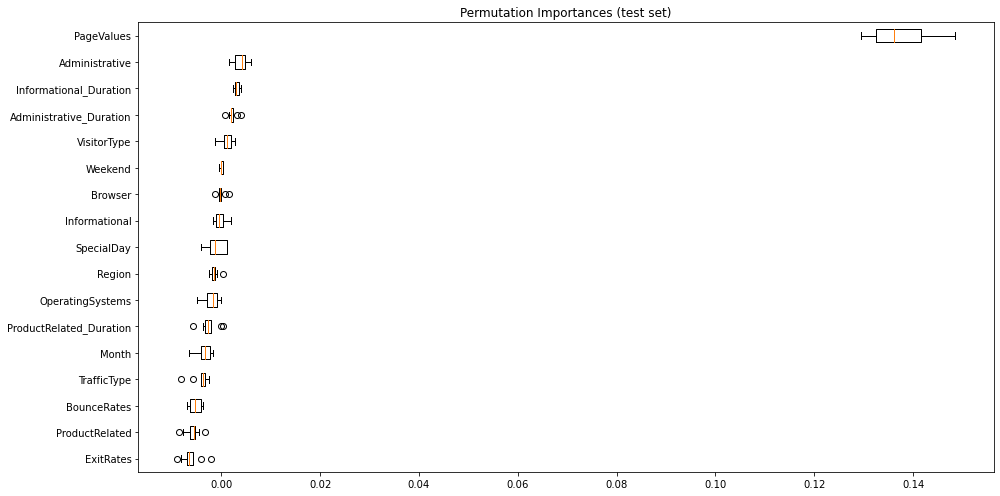

In [29]:
# Display permutation importance
# source: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(14,7))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

As we can see above, in the test set, *PageValues* is a **highly important predictor** for our trained model. Meaning that it helps the most, out of the features we have, to differentiate between revenue and not revenue for the **unseen data**. There is a dramatic decrease in importance after that.
- **PageValues**: Represent the average value for a web page that a user visited before completing an e-commerce transaction. Which makes sense for it to be important for revenue prediction because, speaking from experience, if we are really interested in buying a product we tend to go back and forth between websites to decide on where and what to buy

Starting from second ranked feature(*Administrative*), the decrese in the importance is gradual

Starting from *Operating systems* variable and other less important variables are actually causing our model to perform worse **in general** for the test set, based on negative permutation importance score

- Now that we tested our model on the test set and realized how features affect our model, we can decide on what features to include or not for the next updated model if we have more data. Ex. try **dropping** *ProductRelated* feature from the model...

## Best model's test set performance on several evaluation metrics

In [24]:
# Get predictions from the best model

predictions = best_model.predict(X_test)

In [25]:
# Define which metrics to look at
metrics_to_test = [balanced_accuracy_score, recall_score, precision_score, f1_score]

### Why such metrics?

- For imbalanced datasets, **accuracy** score might not be the best indicator for model performance
- Because of that reason, we check **balanced accuracy** score but that itself is not enough to look at
- We also would like to see the **recall** and **precision** performance of our model on such imbalanced dataset
- In addition to such metrics, we might want to look at **f1 score** to see how well our model performs when we combine precision and recall performances
- On top of all, **confusion matrix** acts like an icing on the cake to better see the overall picture in terms of performance

In [26]:
# print metric names and corresponding scores
for metric in metrics_to_test:
    print(f"{metric.__name__} is {metric(y_test, predictions):.3f}", end='\n\n')

balanced_accuracy_score is 0.842

recall_score is 0.796

precision_score is 0.567

f1_score is 0.662



In [27]:
# Look at the confusion matrix

confusion_matrix(y_test, predictions)

array([[1852,  232],
       [  78,  304]])

## Conclusion

- **Random Forest** algorithm performed better than Logistic Regression in terms of **predictive power**

- Time to do hyperparameter search with cross validation for Random Forest was relatively **longer** than the Logistic Regression model

- Based on **balanced accuracy** and **recall**, our model **performs relatively well**. Accuracy score suggests that we can correctly classify 84.2% of the user sessions if they will cause a revenue or not. We have a recall score of 79.6% in that sense

- But if we look at our 56.7% **precision score**, we can see that our model is **over-predicting** a user causing a revenue(High false positive) and performing poorly in that sense. This might be because of our model not learning enough about the class *causing a revenue* as a result of having an **imbalanced dataset**

- 66.2% f1 score suggests that the model performs okay if we care equally about recall and precision based on business decisions.

- **Overall**: Our model's performance depend on **what we expect** from it and the **business goals**. It doesn't perform great in every aspect, but it performs well in terms of accuracy and recall. 

## Why does this project matter?

- Customers who aren’t making a purchase can be analyzed in detail and further action can be taken accordingly to increase revenue

## Summary

- 1) Select dataset and research question
- 2) Examine data to understand features, identify missing values, and EDA to detect any anomalies in the data
- 3) Split data before doing any imputation and modeling to prevent leaking
- 4) Select which features are going to be in the model, and create new variables from existing ones if appropriate
- 5) Preprocess categorical and continuos variables accordingly
- 6) Decide on which algorithms and hyperparameters to search for and do CV search to chose the best model based on a certain metric
- 7) Select the best model and gather insights by looking at feature importance and different evaluation metrics

## Next Steps

- Features that are found to be bad by permutation importance can be taken out from the model and retraining can be done to see if there will be an improvement
- Collect more data about the minority class, if it makes sense in terms of cost/return
- Different prediction algorithms can be added for better performance comparison, ex. LightGBM